<a href="https://colab.research.google.com/github/MasaAsami/LTsandox/blob/main/notebooks/Chap5_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install -q torch===1.2.0 torchvision===0.4.0 -f https://download.pytorch.org/whl/torch_stable.html


     |████████████████████████████████| 748.9 MB 414 bytes/s 
     |████████████████████████████████| 8.8 MB 31.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.13.1 requires torch==1.12.1, but you have torch 1.2.0 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.2.0 which is incompatible.
fastai 2.7.9 requires torch<1.14,>=1.7, but you have torch 1.2.0 which is incompatible.
fastai 2.7.9 requires torchvision>=0.8.2, but you have torchvision 0.4.0 which is incompatible.


In [7]:
# @title パッケージ色々いれる
import warnings
warnings.filterwarnings('ignore')

import random
import cv2
import numpy as np
import base64
from base64 import b64decode
import html


from PIL import Image
from io import BytesIO
import io

import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

import seaborn as sns

import IPython.display
from IPython.display import display, Javascript, clear_output
from google.colab.output import eval_js


# 5.1 単純型細胞と複雑型細胞


読み物なので各自読もう

## 視覚野


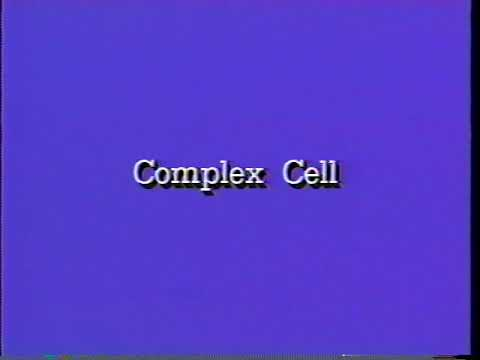

In [4]:
from IPython.display import YouTubeVideo
YouTubeVideo('Q6eKK1BeiDI', width=400, height=300)

## ネオコグニトロン

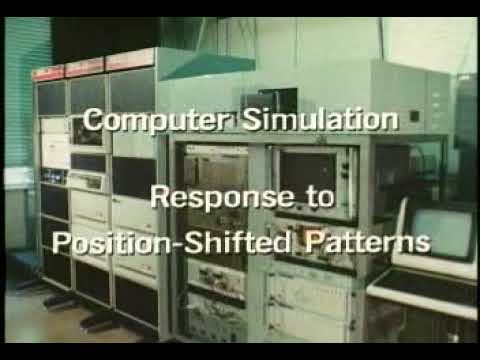

In [3]:
YouTubeVideo('oVYCjL54qoY', width=400, height=300)

# 5.1 畳み込み
- サンプルデータで解説していこう

In [27]:
# @title
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename


In [29]:
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

Saved to photo.jpg
'module' object is not callable


REDチャンネル


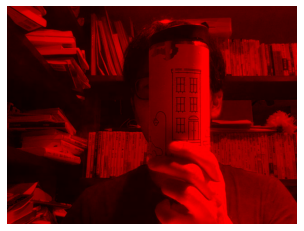

GREENチャンネル


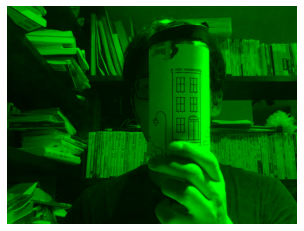

BLUEチャンネル


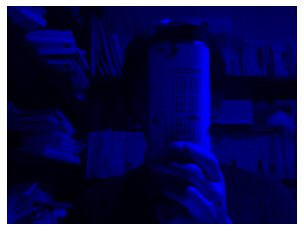

In [30]:
#@title RGBの確認 { display-mode: "form" }
# https://konchangakita.hatenablog.com/entry/2021/01/15/210000

img = Image.open(filename)
img_array = np.asarray(img)  # (H, W, Ch)

def get_channel(image,channel='r'):
    # イメージをコピー
    new_image = image.copy()
    if channel=='r':
        # 「r」が指定された場合、「g」「b」は0にする
        new_image[:,:,1] = 0
        new_image[:,:,2] = 0
    elif channel=='g':
         # 「g」が指定された場合、「r」「b」は0にする
        new_image[:,:,0] = 0
        new_image[:,:,2] = 0
    elif channel=='b':
         # 「g」が指定された場合、「r」「b」は0にする
        new_image[:,:,0] = 0
        new_image[:,:,1] = 0
    return new_image


print("REDチャンネル")
image_2 = get_channel(img_array,channel='r')
plt.imshow( image_2 )
plt.axis("off")
plt.show()

print("GREENチャンネル")
image_2 = get_channel(img_array,channel='g')
plt.imshow( image_2 )
plt.axis("off")
plt.show()

print("BLUEチャンネル")
image_2 = get_channel(img_array,channel='b')
plt.imshow( image_2 )
plt.axis("off")
plt.show() 

In [31]:
img_array.shape

(480, 640, 3)

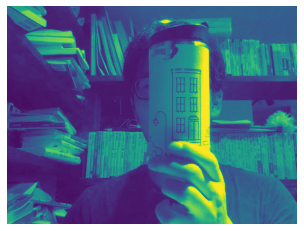

In [32]:
#@title 簡易化のために１チャンネルにまとめる { display-mode: "form" }
# grayスケールに変更
gray_img = np.array(0.2989 * img_array[:,:,0] + 0.5870 * img_array[:,:,1] + 0.1140 * img_array[:,:,2], dtype='uint8')

plt.imshow(gray_img)
plt.axis("off")
plt.show()

# 5. 2 畳み込み
## 5.2.1 定義
- 画像サイズ W*H
- 画素のインデックスを(i,j) i in [0, W-1], j in [0, J-1]
- 畳み込みfilter (kernel)のサイズを$W_f$ * $H_f$とし、その要素インデックスを(p,q)とする
$$
u_{ij} =  \sum_{p=0}^{W_f - 1}  \sum_{q=0}^{H_f -1} x_{i+p, j+q} h_{pg}
$$

## 5.2.2 畳み込みの動き
- 教科書読んで納得できない人は、以下のサイトのgifをみよう <br>
　[CS231n Convolutional Neural Networks for Visual Recognition](
https://cs231n.github.io/convolutional-networks/)

In [12]:
#@title 畳み込み関数 { display-mode: "form" }
def zero_pad(img, pad):
    img_pad = np.pad(img, ((pad, pad), (pad, pad)), mode = 'constant', constant_values = (0, 0))

    return img_pad

def conv_filter(img, stride, padding, kernel):
    h, w = img.shape
    f, f = kernel.shape

    n_h = int(int(h + 2 * padding - f) / stride + 1)
    n_w = int(int(w + 2 * padding - f) / stride + 1)
    z = np.zeros([n_h, n_w])

    img_pad = zero_pad(img, padding)

    for h in range(n_h):
        vertical_start = stride * h
        verttical_end = vertical_start + f
        for w in range(n_w):
            horizontal_start = stride * w
            horizontal_end = horizontal_start + f
            target = img_pad[vertical_start:verttical_end, horizontal_start:horizontal_end]
            conv = np.multiply(target, kernel)
            conv_sum = np.sum(conv)
            z[h, w] = conv_sum

    return z

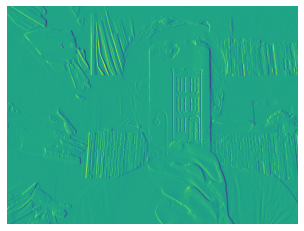

In [33]:
kernel_x = np.array(
    [[-1, 0,  1],
     [-1, 0,  1],
    [-1, 0,  1]]
    )

sobel_img = conv_filter(gray_img, stride = 1, padding = 0, kernel = kernel_x)
plt.imshow(sobel_img)
plt.axis("off")
plt.show()

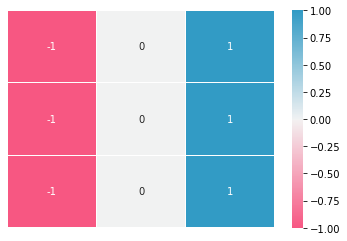

In [34]:
#@title 上はこんなフィルターを使っている { display-mode: "form" }
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

sns.heatmap(kernel_x,  cmap=cmap, annot=True, fmt="d", linewidth=0.3)
plt.axis("off")
plt.show()

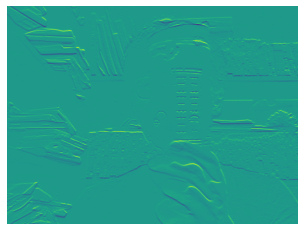

In [35]:
kernel_y = np.array([[-1, -1, -1],
                     [0,   0,  0],
                     [1,   1,  1]])

sobel_img = conv_filter(gray_img, stride = 1, padding = 0, kernel = kernel_y)
plt.imshow(sobel_img)
plt.axis("off")
plt.show()

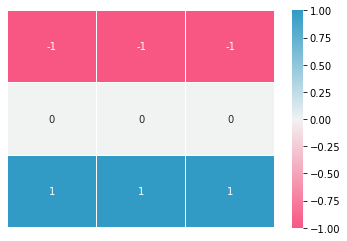

In [36]:
#@title 上はこんなフィルターを使っている { display-mode: "form" }
sns.heatmap(kernel_y,  cmap=cmap, annot=True, fmt="d", linewidth=0.3)
plt.axis("off")
plt.show()

## 5.2.3 パディング
- 上の実装はゼロパディング
- ゼロパディングの弊害（時々ご利益）もあるので注意


## 5.2.4 ストライド
- フィルタを１画素ずつ動かすならstride=1
- ダウンサンプリングを目的としてstride>1でもいい。後述のプーリングの代用にもなる


# 5.3 畳み込み層
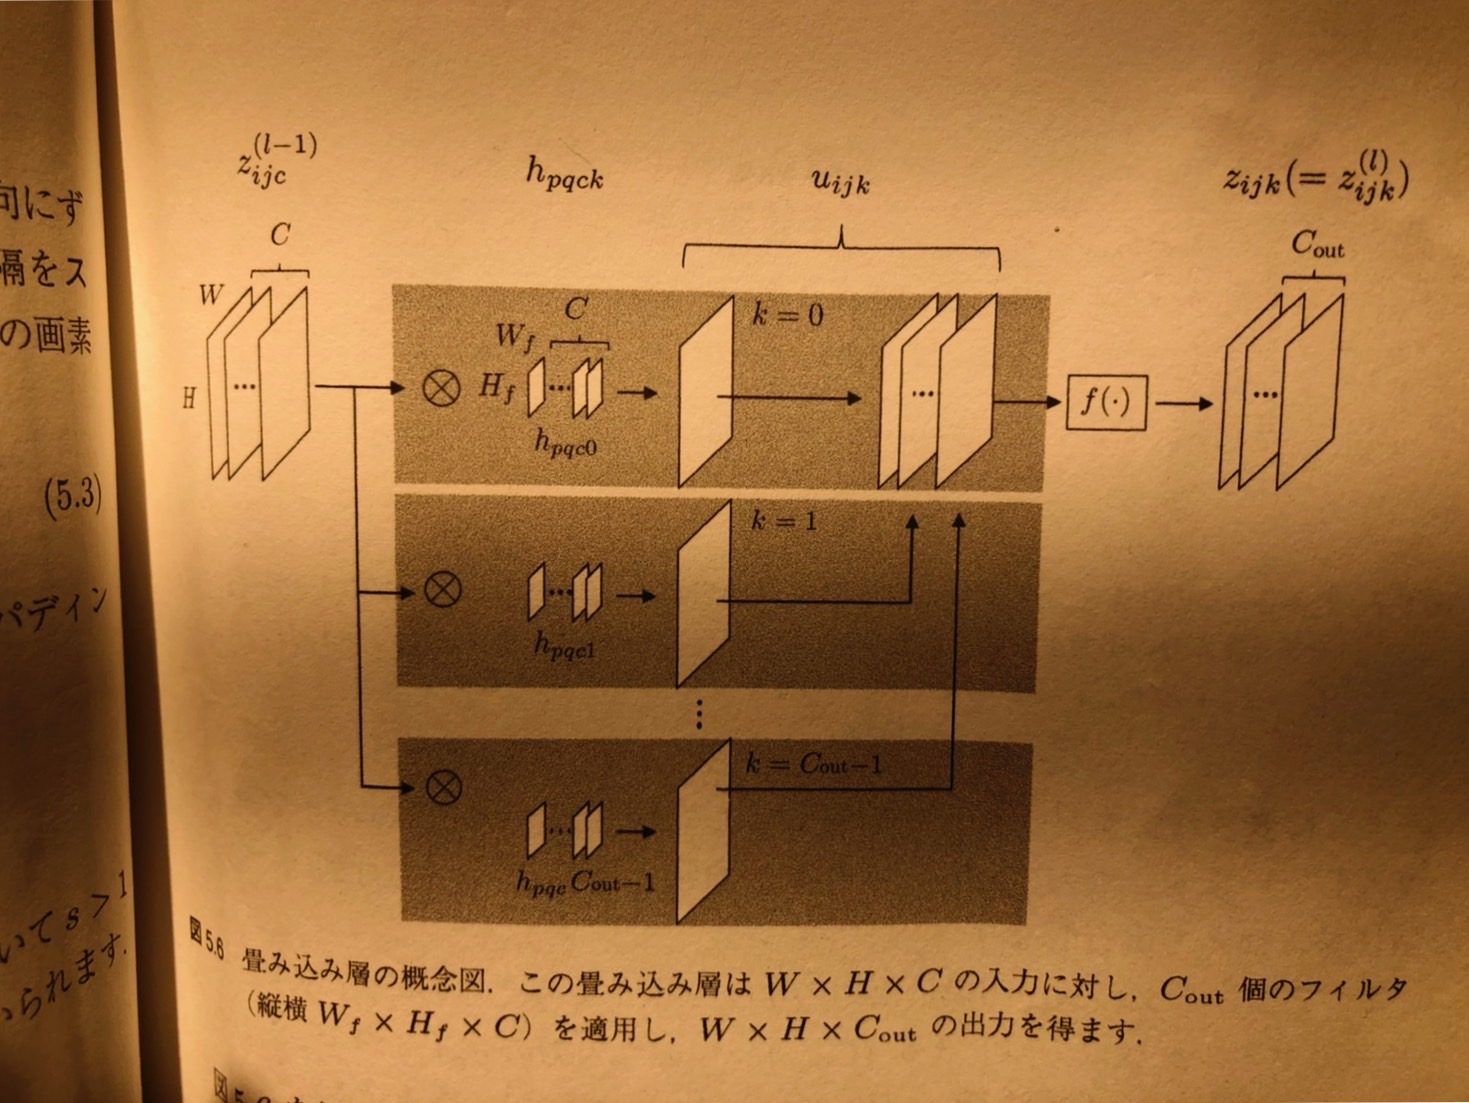

- 上の例では、グレースケール（チェンル数＝１）で説明した。でも実際はテンソル。
- RGBであればW*H*Cのテンソル（３次元配列）となる
- ここでl-1層のoutがW*H*Cの入力 $z^{(l-1)}_{i,j,c}$を受け取り、
- $C_{out}$種類のフィルタ$h_{pqck}$を適用する畳み込み層を定義する
- 各フィルタのインデックスをk とする

$$
u_{ijk} =  \sum_{c=0}^{C - 1}　\sum_{p=0}^{W_f - 1}  \sum_{q=0}^{H_f -1} z^{(l-1)}_{i+p, j+q,c} h_{pgck} + b_k
$$

- 図からも分かる通り、出力のチャネル数はフィルターの種類の数と一致

# 5.4 プーリング層
- 局所領域内の要約とダウンサンプリング
- 物体の局所変動に対してロバストなモデルにしたいよね
- プーリング層は要約してるだけなので、学習しない。また活性化関数も適用しない
- いろんな種類
    - Maxプーリング
    - 平均プーリング
    - Lpプーリング
- 最近では、ストライド＞１で代用されることも多くなってきてる
- max プーリングを実装してみよう

In [37]:
def max_pool(img, factor: int):
    """ 
    Perform max pooling with a (factor x factor) kernel
    引用：https://stackoverflow.com/questions/42463172/how-to-perform-max-mean-pooling-on-a-2d-array-using-numpy
    """
    ds_img = np.full((img.shape[0] // factor, img.shape[1] // factor), -float('inf'), dtype=img.dtype)
    np.maximum.at(ds_img, (np.arange(img.shape[0])[:, None] // factor, np.arange(img.shape[1]) // factor), img)
    return ds_img

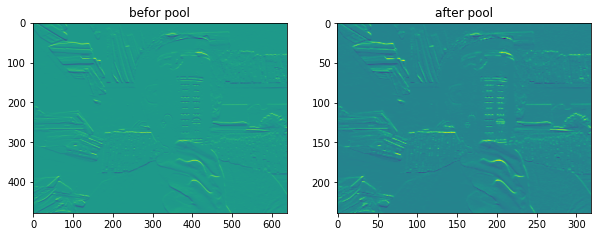

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(10,7))
 
axs[0].imshow(sobel_img)
axs[0].set_title("befor pool")

axs[1].imshow(
    max_pool(sobel_img , 2)
)
axs[1].set_title("after pool")

plt.show()


- poolingしてダウンサンプリングされているのが分かる
- 物体の微小変動に対してロバスト

### Global Average Pooling（GAP）大域平均プーリング
- やや上と異なり、クラス分類の出力層付近で使われる
- 各チャネルを１次元に要約
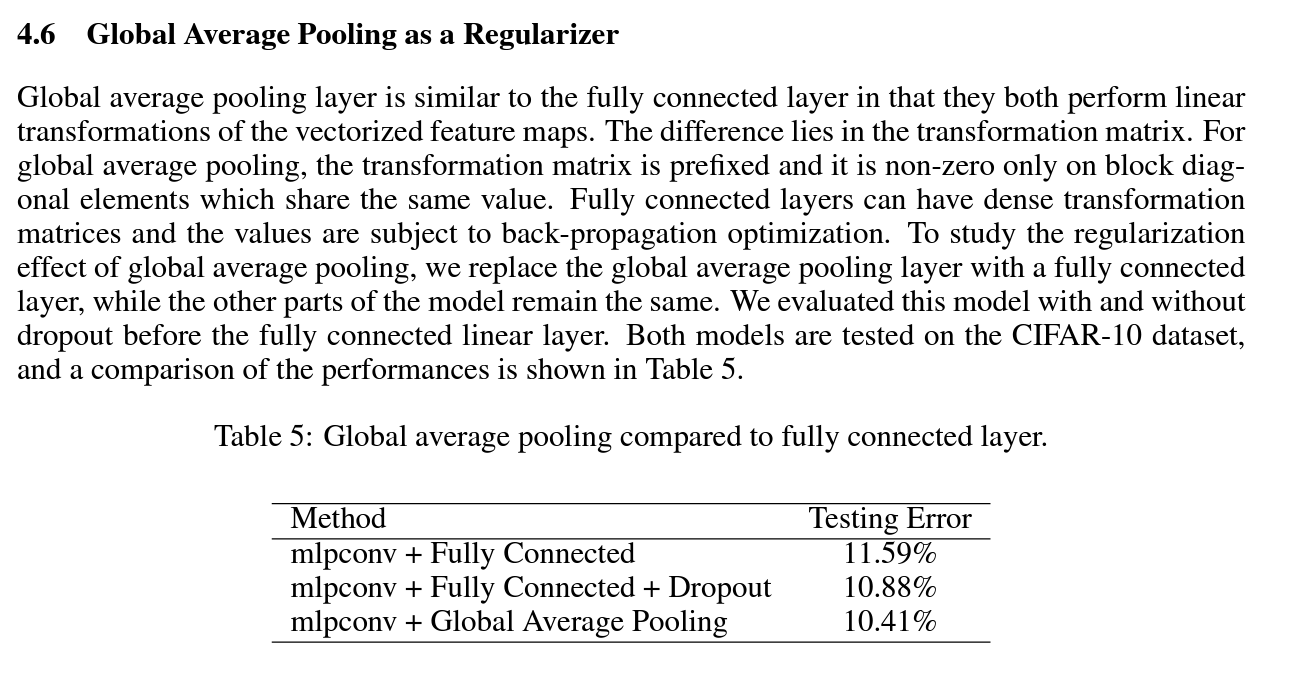

- fully connected はパラメータ $W^{(l-1)} * H^{(l-1)} * C^{(l-1)}$分のパラメータが必要になってきますよね？
- これをGAPで代用してよければとても楽ですよね？楽どころか、上記の通りtesting error小さいですよね？
- 論文 Lin, M., Chen, Q., & Yan, S. (2013). [Network in network.](https://arxiv.org/pdf/1312.4400.pdf) arXiv preprint arXiv:1312.4400.

# 5.5 畳み込み層の出力の正規化
## 5.5.1 バッチ正規化
Wu, Y., & He, K. (2018). [Group normalization](https://arxiv.org/pdf/1803.08494.pdf). In Proceedings of the European conference on computer vision (ECCV) (pp. 3-19).
- Batch Normalization：ミニバッチごとに、平均０分散1となるように正規化
    - でもバッチが十分にないときは当然計算できない
- Layer Normalozation : 全チャンネに跨って平均・分散を計算
- Instance Normalization : 各チャンネル独立に画像の縦横方向についてのみ平均・分散を計算
- Group Normalization : チャンネルをグループに分けて計算（Layer NormとInstance Normの中間的な）

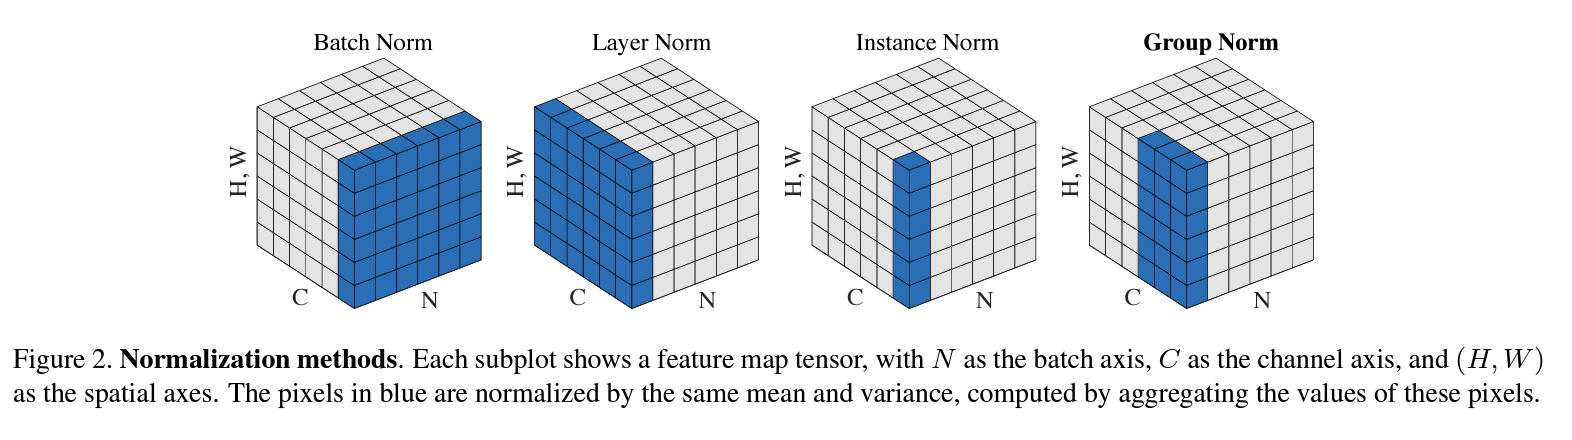

## 5.5.2 局所コントラスト正規化
- 各位置の局所的な範囲で統計量を求めて正規化
- 一般的な画像処理の方法で、かつ誤差逆伝播法での計算もOK
- 畳み込みやプーリングと同様として、１つの層として採用することも可能

# 5.6 推論のためののCNNの構造
## 5.6.1 基本的な構造
- 最近はプーリング層はstride>1で代用
- 最後の畳み込み層からfc層に繋ぐ（VGGNetなど） => GAP層を配置する（ResNetなど）


## 5.6.2 代表的なCNNデザイン
内田さんブログ　[畳み込みニューラルネットワークの最新研究動向 (〜2017)](https://qiita.com/yu4u/items/7e93c454c9410c4b5427)

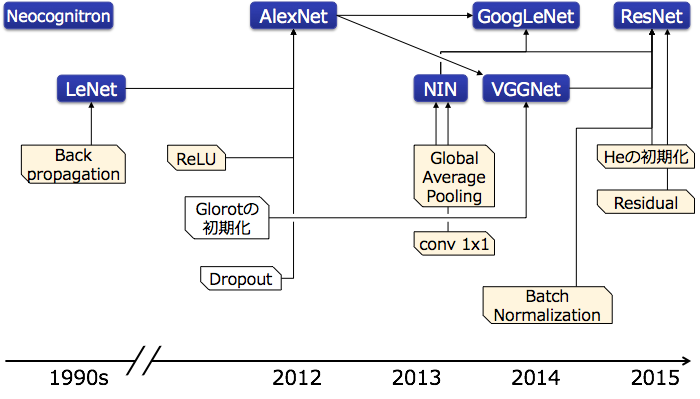

## ResNet のブレイクスルー
「ある層で求める最適な出力を学習する」から「層の入力を参照した残差関数を学習する」 へ<br>
まずは、大元の論文を確認 <br> He, K., Zhang, X., Ren, S., & Sun, J. (2016). [Deep residual learning for image recognition.](https://arxiv.org/pdf/1512.03385.pdf) In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).


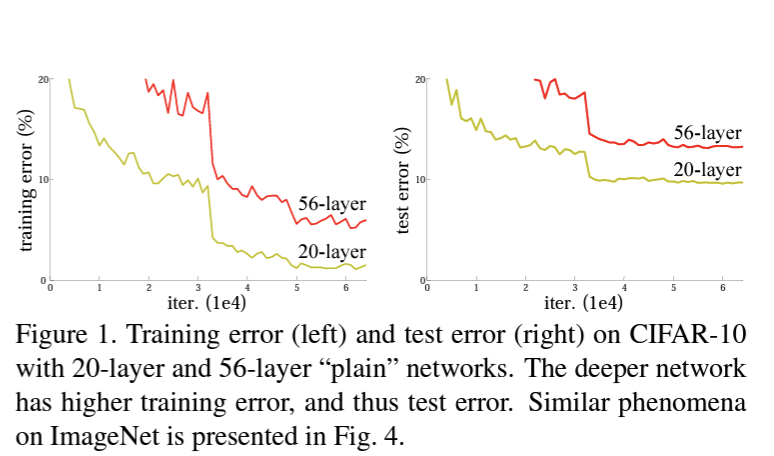

- testデータで多層netが負けるのは理解できる（過学習）。でも、trainデータで負けるのはかなり驚きでは？
- 普通のDNNは恒等写像（identity mapping, identity function）を表現するのが難しかった
- ResNetはテイラー展開のようなアナロジーで関数近似を実現
$$
h_{t+1} = h_t+F_t(h_t)
$$
- パラメータは増えていない。計算量も増えていない（厳密には合流させるために、テンソルのオーダーを合わせる処理は加わってるけど）
- そして、多層が低層ネットに勝てるアーキテクチャを実現

He, K., Zhang, X., Ren, S., & Sun, J. (2016, October). [Identity mappings in deep residual networks.](https://arxiv.org/pdf/1603.05027.pdf) In European conference on computer vision (pp. 630-645). Springer, Cham.
- 元祖論文の活性化関数の位置を合流前に修正

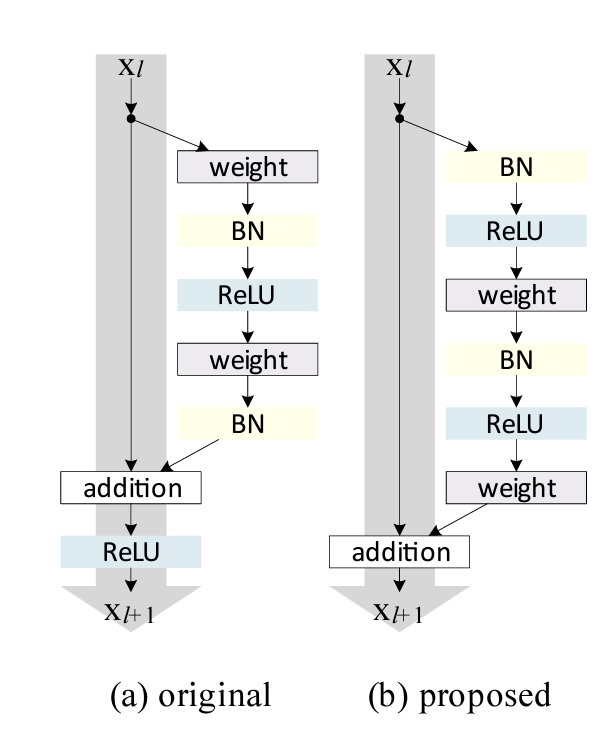

[余談１] 常微分方程式としてのResNet <br>
Chen et al. (2018) [Neural ordinary differential equations.](https://arxiv.org/pdf/1806.07366.pdf) NeurIPS Best Paper.

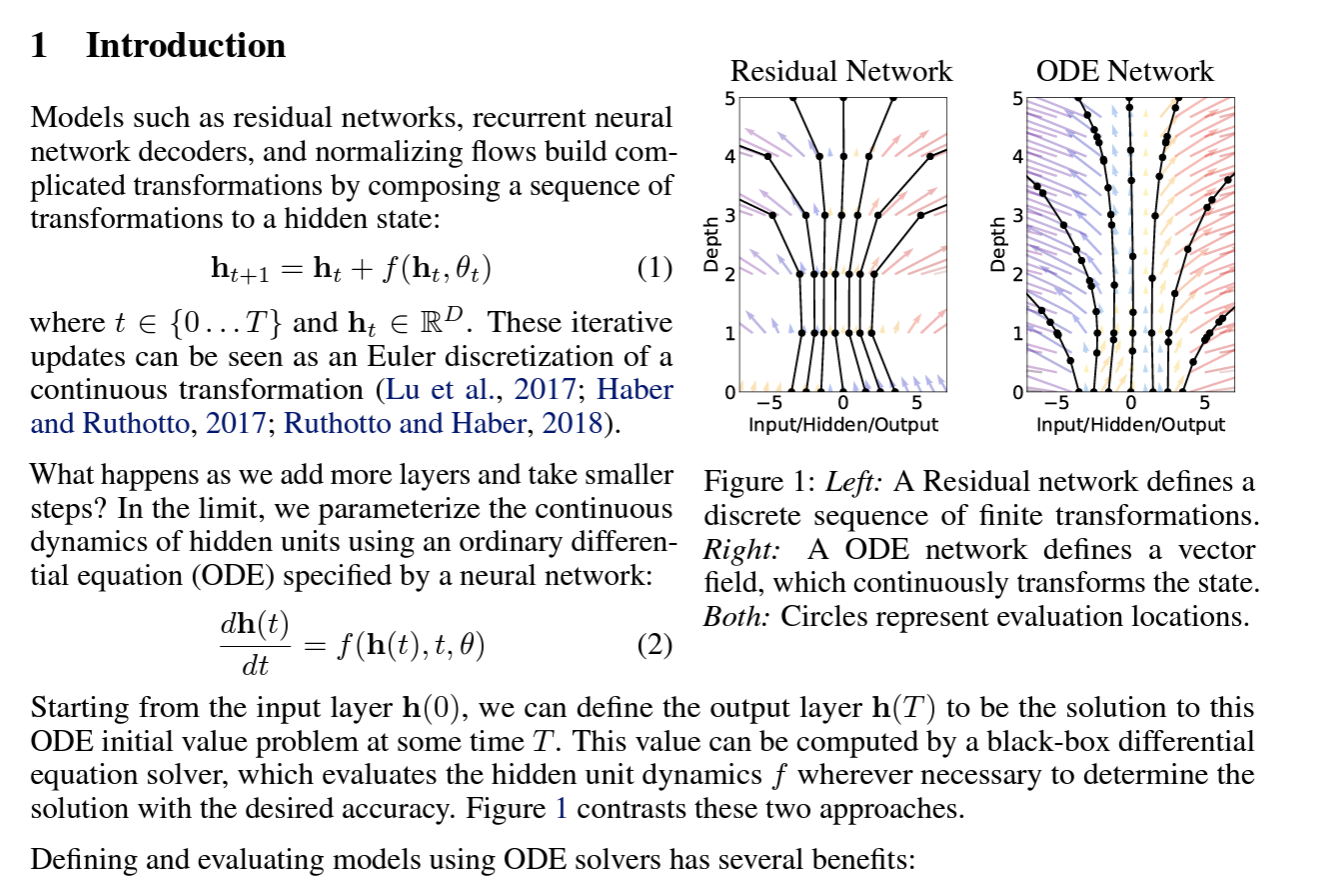

[余談２] ResNetと勾配ブースティングって似てるよね
- そこらへんの関連論文あり : ResFGB (ICML2018)

# 5.7 入出力間の幾何学的関係
## 5.7.1 同変性と不変性
- 畳み込みは、並行移動に対して同変性(equivariant)をもつ

## 5.7.2 ダウンサンプリングと画像上の受容野

- ダウンサンプリングは、物体の微小変動を吸収してくれる
- 複雑型細胞の働きに対応

## 5.7.3 任意サイズの画像の入力
- VGGのような、畳み込み層から出力層へFCを行なっているアーキテクチャは画像サイズは規定のものしか対応できない
- ResNetのようなGAP層で対応しているものは、サイズのズレをGAP層で吸収しているので、自由なサイズの入力を受け取れる


# 5.8 畳み込み層の一般化

## 5.8.1 畳み込み層としての全結合層（FC層）
- FC層も畳み込み層の特殊なケース

## 5.8.2 特別な畳み込み
- 点単位の畳み込み：チャネル方向の情報集約
- グループ別畳み込み：チャネルグループごとに情報集約
- 拡大畳み込み : フィルタをアップサンプリングして畳み込み
　- (あさみコメント) ResNet以前は、低層ネットでできるだけ大局的な特徴量を得るために使われてたのかなーと。多層化できることによって、局所特徴量の積み上げで、大域的な特徴量を獲得できるはず。なので、最近はあんまり見ない気がする

## 5.8.3 多次元の畳み込み
- 次元数が増えても、同じように一般化できるよという話




## 5.8.4 幾何学的変換の学習
- CNNは並行移動にロバストな特徴量を抽出することは可能ですが、向きやサイズの変換などの幾何学的変換は不向き

### 幾何学的変換機構 spatial transformer (ST)
- あとで書く